# Credit Card Fraud Detection: A Crisp DM Approach

### Business Understanding

Credit Card Fraud Detection is a classic class-imbalance problem where the number of fraud transactions is much lesser than the number of legitimate transaction for any bank. Most of the approaches involve building model on such imbalanced data, and thus fails to produce results on real-time new data because of overfitting on training data and a bias towards the majoritarian class of legitimate transactions. Thus, we can see this as an anomaly detection problem. 

1. What time does the Credit Card Frauds usually take place?
2. What are the general trends of amounts for Credit Card Fraud Transactions?
3. How do we balance the data to not let the model overfit on legitimate transactions?


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from mlxtend.plotting import plot_learning_curves
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

### Data Understanding
The Dataset we use is the Kaggle Credit Card Fraud Detection Dataset enlisted in the following link: <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Link</a>

- The Data has 32 features from V1-V28 which are unknown for confidentiality, TIme, Amount and Class
- The input features are V1-V28, Time and Amount
- The target variable is Class
- The Data does not have any missing values as evident from the below mentioned code, thus need not be handled
- The Data consists of all numerical features, and only the Target Variable Class is a categorical feature.
    - Class 0: Legitimate Transaction
    - Class 1: Fraud Transaction

In [3]:
# Read Data into a Dataframe
df = pd.read_csv('/content/drive/MyDrive/Credit-Card-Fraud-Detection-master/data/creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data Preparation

- The Data does not have any missing values and hence, need not be handled.
- The Data has only Target Variable Class as the categorical variable.
- Remaining Features are numerical and need to be only standardized for comparison after balancing the dataset
- The mean of the amount of money in transactions is 88.34
- The standard deviation of amount of money in transactions is 250.12
- The time is distributed throughout the data equitably and hence, serves as an independent feature
- It is best to not remove or drop any data or features in this case and try to tune the model assuming them as independent features initially

In [5]:
# Describe Data
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

<Axes: xlabel='Class', ylabel='Amount'>

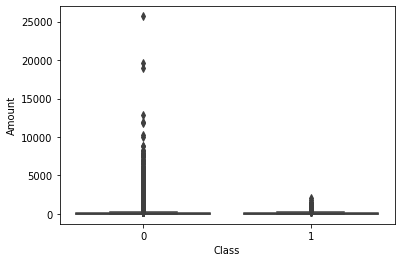

In [8]:
sns.boxplot(x ='Class', y= 'Amount', data =df )

In [9]:
def countplot_data(data, feature):
    '''
        Method to compute countplot of given dataframe
        Parameters:
            data(pd.Dataframe): Input Dataframe
            feature(str): Feature in Dataframe
    '''
    plt.figure(figsize=(10,10))
    sns.countplot(x=feature, data=data)
    plt.show()

def pairplot_data_grid(data, feature1, feature2, target):
    '''
        Method to construct pairplot of the given feature wrt data
        Parameters:
            data(pd.DataFrame): Input Dataframe
            feature1(str): First Feature for Pair Plot
            feature2(str): Second Feature for Pair Plot
            target: Target or Label (y)
    '''

    sns.FacetGrid(data, hue=target).map(plt.scatter, feature1, feature2).add_legend()
    plt.show()
        

In [10]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

### Insights:
- The Dataset has 32 columns with unknown features labelled V1 to V28, Time, Amount and Class
- The target variable is 'Class' and rest of the variables are input features
- The Class has the following values:
    - 0: Legitimate Transactions
    - 1: Fraud Transactions
- The Dataset is highly imbalanced as evident from the countplot with majoritarian class label '0' and minority class label '1'
- Thus, if we run the model on such imbalanced data we may end up highly overfitting it on the data and resulting in non-deployable model
- Hence, we will perform Synthetic Minority Oversampling on the data to balance it out as shown later after exploring other features.

### What is relationship of fraud transactions with amount of money?
Let us try to determine the nature of transactions which are fraud and obtain a relevant set of the same with respect to their amount.
- We hypothesise based on our scatter plot that all fraud transactions occur for an amount less than 2500.

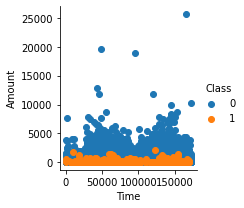

In [11]:
pairplot_data_grid(df, "Time", "Amount", "Class")

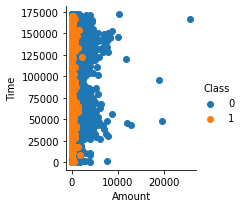

In [12]:
pairplot_data_grid(df, "Amount", "Time", "Class")

### Insights:
- It can be observed that the fraud transactions are generally not above an amount of 2500.
- It can also be observed that the fraud transactions are evenly distributed about time.
- Let us try to prove it

In [13]:
amount_more = 0
amount_less = 0
for i in range(df_refine.shape[0]):
    if(df_refine.iloc[i]["Amount"] < 2500):
        amount_less += 1
    else:
        amount_more += 1
print(amount_more)
print(amount_less)
    

NameError: ignored

In [ ]:
percentage_less = (amount_less/df.shape[0])*100
percentage_less

Hence, we observe that the 99.85% of transactions amount to less than 2500.
Let us see how many of these are fraud and others legitimate

In [ ]:
fraud = 0
legitimate = 1
for i in range(df_refine.shape[0]):
    if(df_refine.iloc[i]["Amount"]<2500):
        if(df_refine.iloc[i]["Class"] == 0):
            legitimate += 1
        else:
            fraud+=1
print(fraud)
print(legitimate)

In [ ]:
df_refine = df[["Time", "Amount", "Class"]]
sns.pairplot(df_refine, hue="Class", size=6)
plt.show()

In [ ]:
df.Class.value_counts()

Thus, we can conclude that since the number of fraud transaction below the amount of 2500 is same as the number of total fraud transactions. Hence, all fraud transactions are less than 2500.

### What is the relationship between Time and Transactions?

In [ ]:
sns.FacetGrid(df_refine, hue="Class", size=6).map(sns.distplot,"Time").add_legend()
plt.show()

From the above distribution plot, it is clear that the fraudulent transactions are spread throughout the time period

### Modelling
- Study the Feature Correlations of the given data
- Plot a Heatmap
- Run GridSearch on the Data
- Fine Tune the Classifiers
- Create Pipelines for evaluation

<Axes: >

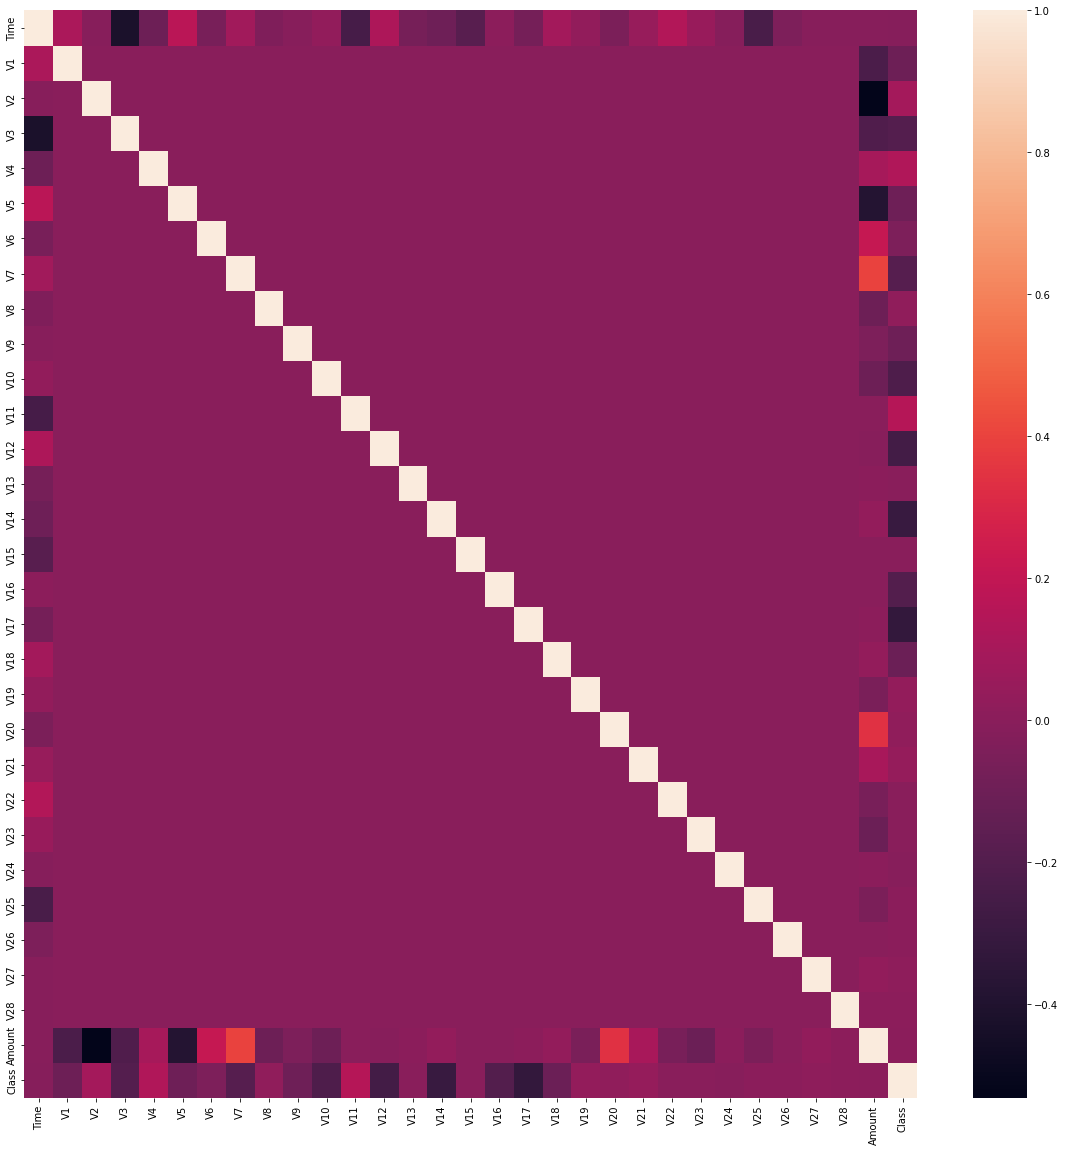

In [14]:
plt.figure(figsize=(20,20))
df_corr = df.corr()
sns.heatmap(df_corr)

In [15]:
# Create Train and Test Data in ratio 70:30
X = df.drop(labels='Class', axis=1) # Features
y = df.loc[:,'Class']               # Target Variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### How will you balance the fraud and legitimate transactions in data?

In [16]:
# Use Synthetic Minority Oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [17]:
from sklearn.feature_selection import mutual_info_classif
mutual_infos = pd.Series(data=mutual_info_classif(X_res, y_res, discrete_features=False, random_state=1), index=X_train.columns)

In [18]:
mutual_infos.sort_values(ascending=False)

V14       0.535044
V10       0.464775
V12       0.456052
V17       0.438193
V4        0.427427
V11       0.404040
Amount    0.392909
V3        0.387187
V16       0.335317
V7        0.304171
V2        0.291484
V9        0.256678
Time      0.247989
V21       0.235010
V27       0.229914
V1        0.220736
V18       0.198262
V8        0.174371
V6        0.171973
V28       0.170495
V5        0.157362
V20       0.107488
V19       0.099836
V23       0.067332
V24       0.063567
V26       0.046974
V25       0.031606
V22       0.031539
V13       0.024931
V15       0.022442
dtype: float64

<Axes: ylabel='count'>

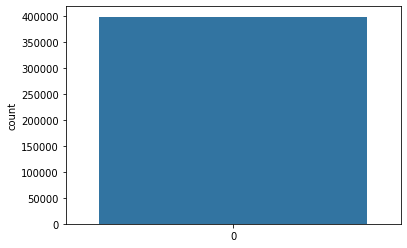

In [19]:
sns.countplot(y_res)

Hence, we can say that the most correlated features after resolving class imbalance using Synthetic Minority Oversampling are V14, V10, V4, V12 and V17.

### Evaluation

We make use of AUC-ROC Score, Classification Report, Accuracy and F1-Score to evaluate the performance of the classifiers

In [20]:
# Evaluation of Classifiers
def grid_eval(grid_clf):
    """
        Method to Compute the best score and parameters computed by grid search
        Parameter:
            grid_clf: The Grid Search Classifier 
    """
    print("Best Score", grid_clf.best_score_)
    print("Best Parameter", grid_clf.best_params_)
    
def evaluation(y_test, grid_clf, X_test):
    """
        Method to compute the following:
            1. Classification Report
            2. F1-score
            3. AUC-ROC score
            4. Accuracy
        Parameters:
            y_test: The target variable test set
            grid_clf: Grid classifier selected
            X_test: Input Feature Test Set
    """
    y_pred = grid_clf.predict(X_test)
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred))
    
    print('AUC-ROC')
    print(roc_auc_score(y_test, y_pred))
      
    print('F1-Score')
    print(f1_score(y_test, y_pred))
    
    print('Accuracy')
    print(accuracy_score(y_test, y_pred))

In [21]:
# The parameters of each classifier are different
# Hence, we do not make use of a single method and this is not to violate DRY Principles
# We set pipelines for each classifier unique with parameters
param_grid_sgd = [{
    'model__loss': ['log'],
    'model__penalty': ['l1', 'l2'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20)
}, {
    'model__loss': ['hinge'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20),
    'model__class_weight': [None, 'balanced']
}]

pipeline_sgd = Pipeline([
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

MCC_scorer = make_scorer(matthews_corrcoef)
grid_sgd = GridSearchCV(estimator=pipeline_sgd, param_grid=param_grid_sgd, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)


grid_sgd.fit(X_res, y_res)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid=[{'model__alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00,...
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                          'model__class_weight': [None, 'balanced'],
                          'model__loss': ['hinge']}],
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [22]:
grid_eval(grid_sgd)

Best Score 0.9560162686072134
Best Parameter {'model__alpha': 0.001, 'model__loss': 'log', 'model__penalty': 'l1'}


In [23]:
evaluation(y_test, grid_sgd, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.14      0.91      0.25       148

    accuracy                           0.99     85443
   macro avg       0.57      0.95      0.62     85443
weighted avg       1.00      0.99      0.99     85443

AUC-ROC
0.9479720619851928
F1-Score
0.2460973370064279
Accuracy
0.990391254988706


In [ ]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])
param_grid_rf = {'model__n_estimators': [75]}
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_rf.fit(X_res, y_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=-1, param_grid={'model__n_estimators': [75]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [ ]:
grid_eval(grid_rf)

Best Score 0.9997538267139271
Best Parameter {'model__n_estimators': 75}


In [ ]:
evaluation(y_test, grid_rf, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.90      0.86      0.88       148

    accuracy                           1.00     85443
   macro avg       0.95      0.93      0.94     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC
0.9323445023075716
F1-Score
0.879725085910653
Accuracy
0.9995903701883126


In [ ]:
pipeline_lr = Pipeline([
    ('model', LogisticRegression(random_state=1))
])
param_grid_lr = {'model__penalty': ['l2'],
                 'model__class_weight': [None, 'balanced']}
grid_lr = GridSearchCV(estimator=pipeline_lr, param_grid=param_grid_lr, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_lr.fit(X_res, y_res)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced'],
                         'model__penalty': ['l2']},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [ ]:
grid_eval(grid_lr)

Best Score 0.959816277887179
Best Parameter {'model__class_weight': None, 'model__penalty': 'l2'}


In [ ]:
evaluation(y_test, grid_lr, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.15      0.91      0.26       148

    accuracy                           0.99     85443
   macro avg       0.57      0.95      0.63     85443
weighted avg       1.00      0.99      0.99     85443

AUC-ROC
0.948212404326479
F1-Score
0.2557251908396946
Accuracy
0.9908711070538253


In [ ]:
pipeline_knn = Pipeline([
    ('model', KNeighborsClassifier(n_neighbors=5))
])
param_grid_knn = {'model__p': [2]}
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_knn.fit(X_res, y_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'model__p': [2]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [ ]:
grid_eval(grid_knn)

Best Score 0.9980623930056313
Best Parameter {'model__p': 2}


In [ ]:
evaluation(y_test, grid_knn, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.50      0.86      0.63       148

    accuracy                           1.00     85443
   macro avg       0.75      0.93      0.82     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC
0.9283095789968995
F1-Score
0.6318407960199005
Accuracy
0.9982678510820079


### Conclusion
- The K-Nearest Neighbors Classifier tuned with Grid Search with the best parameter being the Euclidean Distance (p=2) outperforms its counterparts to give a test accuracy of nearly 99.8% and a perfect F1-Score with minimal overfitting
- SMOTE overcomes overfitting by synthetically oversampling minority class labels and is successful to a great degree

### Summary
- All Fraud Transactions occur for an amount below 2500. Thus, the bank can infer clearly that the fraud committers try to commit frauds of smaller amounts to avoid suspicion.
- The fraud transactions are equitable distributed throughout time and there is no clear relationship of time with commiting of fraud.
- The number of fraud transactions are very few comparted to legitimate transactions and it has to be balanced in order for a fair comparison to prevent the model from overfitting.